### Find intersection

## Equations:
#### - reservoir line :
- P - Gs * D = (Pwf - Gs * D_total)
#### - casing line:
- P - (Pcs/40,000) * D = Pcs

    

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
def get_equations(Pcs,j,BHSP,Q,Gs,D_total):
    """
    get the parametters of the equation of the formation and casing lines at the form
    a * Pressure + b * Depth = Constant
    -------------------------------------
    Pcs : surface injection pressure (psi) 
    j : productivity index 
    BHSP : bottomhole static pressure (psi)
    Q : oil flow rate ( bbl / day)
    Gs : static gradient ( psi/ft )
    D_total : total depth to the perforation (Ft)
    return 
       1- equation of reservoir line
       2- equation of caisng line
    """
    # so that we get injection point
    # the gradient of the surface injection pressure increases so take the gradint of the Pcs put reduce the 
    # intercept 
    # the equation is : ( P = Pcs + ( Pcs/40,000) * D )
    # from the equation the gradient changes with the pressure so , take PCs/40,000 
    # so the equation to get the ingection pint will be  P =(Pcs-100) + (Pcs/40,000) * D
#     Pcs= Pcs-100
    Gcs = Pcs/40000
    Pwf= BHSP-(Q/j)
    # reservoir line 
    reservoir_line = [1 ,-Gs, (Pwf - (Gs* D_total))]
    # casing line
    casing_line = [1,-Gcs,Pcs-100]
    
    return reservoir_line, casing_line

In [3]:
# get_equations()

In [4]:
reservoir_line,casing_line= get_equations(870,2.55,2000,600,.5,7500)
reservoir_line,casing_line

([1, -0.5, -1985.2941176470588], [1, -0.02175, 770])

In [5]:
def find_intersection(line_1,line_2):
    """
    Find intersection of two lines using the cramers-rule 
    -------------------------------------------------
    line_1 : coef of line_1 , in the form (a*P + b*Depth = c) , put list of [a1,b1,c1]
    line_2 : coef of line_2 , in the form (a*P + b*Depth = c) , put list of [a2,b2,c2]
    return : X,Y of the intersection
    ------------------------------------------------
    D = [[a1,b1],
         [a2,b2]]
    Dx= [ [c1,b1],
          [c2,b2]]
    Dy= [ [a1,c1],
          [a2,c2]]
          
    """
    Z= np.array([ [line_1[0],line_1[1]],[line_2[0],line_2[1]] ])
    X= np.array([ [line_1[-1],line_1[-2]],[line_2[-1],line_2[-2]] ])
    Y= np.array([ [line_1[0],line_1[-1]],[line_2[0],line_2[-1]] ])
    try:
        D = np.linalg.det(Z)
        Dx= np.linalg.det(X)
        Dy= np.linalg.det(Y)
        P= Dx/D
        Depth= Dy/D 
        return np.round(Depth,2) , np.round(P,2)
    except:
        print("Error, there is no intersection")

In [6]:
find_intersection([1,-.4,-1200],[1,-0.03,1200])

(6486.49, 1394.59)

In [7]:
find_intersection(reservoir_line,casing_line)

(5761.2, 895.31)

In [8]:
def get_GF1_GF2(Tubing_head,Pcs,injection_depth, injection_pressure):
    """
    Tubing_head : tubing head pressure (Psi)
    Pcs : surface casing pressure (Psi)
    injection_depth : depth at the pint of injection (Ft)
    injection_pressure : pressure of the reservoir at the injection point (Psi)
    return : 
        Gf1 -> of the line from the (wellhead[Pwh1] to injection point)
        Gf2 -> of the line from the (modified_wellhead[Pwh2] to injection point
        Pwh2 -> modified wellhead pressure
    """
    Gf1 = (injection_pressure - Tubing_head) / injection_depth
    Pwh2= Tubing_head + 0.2*(Pcs - Tubing_head)
    Gf2=  (injection_pressure - Pwh2) / injection_depth
    return round(Gf1,3) , round(Gf2,3), round(Pwh2,3)

In [9]:
# get_GF1_GF2()
get_GF1_GF2(100,870,5731.241014346458,880.3263895261689)

(0.136, 0.109, 254.0)

## Equations:
#### - gas line :
- P - (Pcs/40,000) = Pcs
#### - first line of the valves:
- P - (Glf * D) = Pwh1
#### -following lines lines:
- P - (Glf * D) = (Pwh2+ Gf2*Di-1) 
    

In [10]:
# the main loop
def get_spacings(Pwh1,Pwh2,Pcs,Pko,Glf,Gf2,injection_depth,injection_pressure):
    # first initiat the lists contain the informations
    # depth for the depths of the valves
    depths=[]
    # P1 -> which is the pressure of the casing
    P1=[]
    # P2 -> the pressure of the tubing
    P2=[]  
    # the parameter of the line of kick_off
    casing_ko=[1,(-Pko/40000),Pko]
    # the parameters of the line from the Pwh1 to Pko
    line_1= [1,-Glf,Pwh1]
    # get the point of intersection between two lines and return the depth and casing pressure
    depth,p1= find_intersection(casing_ko,line_1)
    depths.append(depth)
    P1.append(p1)
    # secnd we get the pressure at the tubing by the formula Pt= Pwh2 + Glf * depth
    p2= Pwh2 + Gf2*depths[-1]
    P2.append(p2)
    # due to the pressure differences we must fix the gradient of the casing line
    Gcs = Pcs/40000
    # using while loop to get the spacing between the valves
    
    while depths[-1] < injection_depth:
        # because the each time i changes the axis , so each time we will cacluate the pressure of the casing 
        # at the previous depth and make the equation of the line
        
        Pc_0 = Pcs*(1+(depths[-1]/40000)) # Pcs at previous depth
       #casing_ps=[1,-Pc_0/40000,Pc_0]
        casing_ps=[1,-Gcs,Pc_0]   # put the parameters of the casing line
        line_2= [1,-Glf,P2[-1]]  # put the parameters of the new_line to get the intersect with
        # get the new depth and new pressure
        depth,p1= find_intersection(casing_ps,line_2)
        # the depth of the new valve is the ( new_depth + previous_depth)
        depths.append(depth + depths[-1])
        P1.append(p1)
        # get the new tubing_pressure 
        p2= Pwh2 + Gf2*depths[-1]
        P2.append(p2)
    # the while loop will end if the depth of the valve exceed the injection_point 
    dics={
    "Depth":np.round(depths,2),
     "P1":np.round(P1,2),
     "P2":np.round(P2,2)
     }

    # make a DataFrame of the data 
    df =pd.DataFrame(dics)
    # as the last depth of the data exceed the injection depth _ so remove the last row
    df.drop(axis=0,index=df.index[-1],inplace=True)
    # so after removing the last row , we will put the informations at the Injection_Depth
    final_depth=np.round(injection_depth,2)
    # get casing_pressure at the injection point
    p1= Pcs * (1+ (final_depth / 40000))
    # the tubing pressure at the injection point
    p2= injection_pressure
    final={
    "Depth":np.round(injection_depth,2),
     "P1":np.round(p1,2),
     "P2":np.round(p2,2)
     }
    # add the new_row
    df=df.append(final,ignore_index=True)
    # the following to check if the last two valves are close to each other
    # if that is True , remove the valve befor the operating vale , the tollerance here is 200 ft
    if (df.loc[df.index[-1],"Depth"] - df.loc[df.index[-2],"Depth"])  < 200:
        df.drop(axis=0,index=df.index[-2],inplace=True)
        
    # write the number of valves
    valves= [i+1 for i in range(len(df["Depth"]))]
    df["Valve .No"]= valves
    # df=df[["Valve .No","Depth","P1","P2"]]
    # reorder the columns and get the final table 
    cols=["Valve .No","Depth","P1","P2"]
    df=df.reindex(columns=cols)
    return df 


In [11]:
df=get_spacings(100,254.0,870,920,.5, 0.10928285653287778,5761.2,895.31)

In [12]:
df 

,Valve .No,Depth,P1,P2
0,1,1719.08,959.54,441.87
1,2,2692.47,928.56,548.24
2,3,3487.70,945.86,635.15
3,4,4137.38,959.99,706.14
4,5,4668.16,971.53,764.15
5,6,5101.79,980.96,811.54
6,7,5456.05,988.67,850.25
8,8,5761.20,995.31,895.31


In [13]:
df.loc[df.index[-1],"Depth"] - df.loc[df.index[-2],"Depth"]

305.14999999999964

In [14]:
casing=[1,(-870/40000),870]
line_2= [1,-.5,440]
depth,p1= find_intersection(casing,line_2) 
p2= 254 + .10928285653287778*2600

In [15]:
depth

899.11

In [16]:
p1

889.56

In [17]:
p2 

538.1354269854822

In [18]:
def all_in_one(total_depth,wellhead_pressure, Pcs ,Pko,Glf,Gs,Q,BHSP,J,Tre,Ts,R):
    """
    total_depth : total depth to the pay zone  ( ft )
    wellhead_pressure : tuning pressure at the surface ( psi )
    Pcs : surface casing pressure ( injection pressure) ( psi )
    Pko : kick_off pressure if it exists ( psi )
    Glf : load flowing gradient ( psi/ft )
    Gs : static gradient ( psi/ft )
    Q : oil flow rate ( bbl/day)
    BHSP : bottom_hole static pressure -> reservoir pressure
    J : productivity index 
    Tres : reservoir temperature ( F )
    Ts : surface following temperature ( F )
    R: port size 
    """
    reservoir_line,casing_line = get_equations(Pcs,J,BHSP,Q,Gs,total_depth)
    injection_depth,injection_pressure = find_intersection(reservoir_line,casing_line)
    Gf1,Gf2,Pwh2 = get_GF1_GF2(wellhead_pressure,Pcs,injection_depth,injection_pressure)
    df=get_spacings(wellhead_pressure,Pwh2,Pcs,Pko,Glf,Gf2,injection_depth,injection_pressure) 
    # make the Ct and get Pd and also Pvo
    Ct_data= pd.read_csv("Ct_Data.csv")
    Tg= ((Tre-Ts) / total_depth)
    df["Temp"] = np.round(Ts + Tg * df["Depth"],2)
    df["Pdt"] = np.round((1-R)*df["P1"] + R*df["P2"],2)
    df["Ct"]= df.Temp.apply(lambda T: (Ct_data[(Ct_data["temp"]== round(T))]["Ct"].values)[0] ) 
    df["Pd"]=round(df["Pdt"] * df["Ct"],2)
    df["Pvo"] = round(df["Pd"] / (1-R) ,2)
    
    return df

In [19]:
df_2=all_in_one(7500,100,870,920,.5,.5,600,2000,2.55,180,100,.1534)

In [20]:
df_2

,Valve .No,Depth,P1,P2,Temp,Pdt,Ct,Pd,Pvo
0,1,1719.08,959.54,444.82,118.34,880.58,0.889,782.84,924.69
1,2,2686.30,928.43,552.18,128.65,870.71,0.871,758.39,895.81
2,3,3473.02,945.54,639.51,137.05,898.59,0.858,770.99,910.69
3,4,4112.92,959.46,710.53,143.87,921.27,0.847,780.32,921.71
4,5,4633.40,970.78,768.31,149.42,939.72,0.839,788.43,931.29
5,6,5056.75,979.98,815.30,153.94,954.72,0.832,794.33,938.26
6,7,5401.10,987.47,853.52,157.61,966.92,0.826,798.68,943.40
8,8,5761.20,995.31,895.31,161.45,979.97,0.822,805.54,951.50


In [21]:
Ct_data= pd.read_csv("Ct_Data.csv")
x=100
(Ct_data[(Ct_data["temp"]==x)]["Ct"].values)[0] 

0.921

In [30]:
def draw(df,Pwf,Pwh1,Pwh2,Pcs,Pko,total_Depth,reservoir_line):
    plt.style.use("seaborn")
    fig,ax=plt.subplots(1,1,figsize=(8,6))
    fig.suptitle("GasList",size=10,padding=10)
    # draw the formation line:
    point1,point2=[df["P2"].iloc[-1],df["Depth"].iloc[-1]], [Pwf,total_Depth]
    ax.plot([point1[0],point2[0]],[point1[1],point2[1]],label="Formation",c="#080cdd")
    # draw the tubing line
    ax.plot([Pwh1,df["P2"].iloc[-1]],[0,df["Depth"].iloc[-1]],label="Tubing",c="#139100")
    # draw the modified tubing line
    ax.plot([Pwh2,df["P2"].iloc[-1]],[0,df["Depth"].iloc[-1]],label="Safty",c="#72f25c")
    # draw the casing line 
    #get_intersection
    d,p=find_intersection(reservoir_line,[1,-Pcs/40000,Pcs])
    ax.plot([Pcs,p],[0,d],label="Casing")
    # ploting the horizontal lines and inclindes lines
    ax.plot([Pwh1,df["P1"].iloc[0]],[0,df["Depth"].iloc[0]],c="#bbb") 
     # horisontal lines
    for index,row in df.iterrows():
        ax.plot([row["P1"],row["P2"]],[row["Depth"],row["Depth"]],c="#bbb") 
    # inclinded lines
    for index,row in df.iterrows():
        if index +1 >= len(df):
            break
        else:
            ax.plot([row["P2"],df["P1"].iloc[index+1]],[row["Depth"],df["Depth"].iloc[index+1]],c="#bbb")
    # draw the line of kick_off
    ax.plot([Pko,df["P1"].iloc[0]],[0,df["Depth"].iloc[0]],label="Kick_off",c="#1e647f")
    plt.gca().invert_yaxis()
    ax.xaxis.tick_top()
    ax.set_xlabel("Pressure (psi)")
    ax.set_ylabel("Depth (ft)")
    ax.xaxis.set_label_position("top")
    plt.legend() 
    plt.show()
    

AttributeError: 'Text' object has no property 'padding'

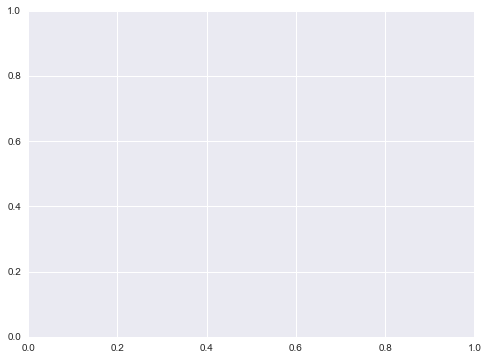

In [31]:
draw(df_2,1764.7,100,254,870,920,7500,reservoir_line)